# HUMAN EMOTION DETECTION

A two-class face emotion detection classifier employs transfer learning with MobileNet as the base model. This approach leverages a pre-trained MobileNet neural network to extract facial features and fine-tunes the model to distinguish between two specific emotions,happy and sad. It efficiently utilizes the pre-trained MobileNet's knowledge, making it a resource-efficient and accurate solution for emotion recognition in facial images.

## Model Setup and Evaluation

The following Python code sets up the environment and imports necessary libraries for building, training, and evaluating a deep learning model for the human emotion detection. This code includes data preprocessing, model architecture definition, and callbacks for model training.

Key libraries used:

- **NumPy:** For numerical operations.
- **Pandas:** For data manipulation and analysis.
- **Matplotlib:** For data visualization.
- **scikit-learn (sklearn):** For machine learning metrics and tools, including confusion matrix, accuracy, precision, recall, and F1 score calculations.
- **Seaborn:** For enhanced visualization of the confusion matrix.

This code serves as the foundational setup for subsequent steps in the deep learning process, including model evaluation and performance analysis.


In [1]:
# Import necessary libraries and modules

import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization
import tensorflow as tf  # TensorFlow for deep learning framework
import logging  # Logging library for tracking messages and errors
import seaborn as sns  # For enhanced data visualization

# Import scikit-learn metrics for model evaluation

from sklearn.metrics import (
    roc_curve,  # ROC curve analysis
    auc,  # Area under the ROC curve
    confusion_matrix,  # Confusion matrix
    accuracy_score,  # Accuracy metric
    precision_score,  # Precision metric
    recall_score,  # Recall metric
    f1_score,  # F1 score metric
)

# Import Keras modules for deep learning

from keras.layers import Flatten, Dense  # Layers for building neural networks
from keras.models import Model  # Model class for defining neural network models
from keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img,
)  # Image data preprocessing
from keras.applications.mobilenet import (
    MobileNet,
    preprocess_input,
)  # MobileNet pre-trained model
from keras.losses import categorical_crossentropy  # Loss function for training
from keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
)  # Callbacks for model training
from keras.models import load_model  # Load pre-trained models

## Human Emotion Detection Model Setup

In this code section, we are setting up a human emotion detection model using transfer learning with a pre-trained MobileNet base. The goal of this model is to recognize and classify human emotions from input images.

**Steps:**

1. **Base Model Selection:** We initialize a MobileNet base as the foundation of our model, configuring it for processing images with a size of 224x224 pixels and excluding the top (classification) layers.

2. **Freezing Base Model Layers:** To leverage the pre-trained features, we freeze all layers in the base model, preventing them from being updated during training.

3. **Flatten and Fully Connected Layer:** We add a Flatten layer to convert the base model's output into a one-dimensional array. Next, a fully connected layer with 2 units (for emotion classification) and softmax activation is introduced.

4. **Final Model:** The resulting model is created by connecting the input to the base model and the output to the new fully connected layer.

This code initializes the structure of our human emotion detection model, which will be further trained and evaluated in subsequent steps.


In [2]:
# Working with pre trained model
base_model = MobileNet( input_shape=(224,224,3), include_top= False )

# Freezing the layers in the base model
for layer in base_model.layers:
  layer.trainable = False

#  layer flattens the output of the base model to a one-dimensional array
x = Flatten()(base_model.output)

# Add a fully connected layer with 2 as well using softmax as the activation function
x = Dense(units=2 , activation='softmax' )(x)

# creating our model.
model = Model(base_model.input, x)

## Compiling Emotion Detection Model

Configuring the model with 'adam' optimizer, categorical cross-entropy loss, and accuracy metric for training preparation.

In [3]:

# Compiling the emotion detection model to prepare it for training as well as configuring the optimizer, loss function, and evaluation metrics.
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

## Data Preparation for Training

In this section, we specify the classes to load ("happy" and "sad"), initialize a training data generator with data augmentation options, and load images for training. The data is prepared for the emotion detection model.


In [4]:
# Specifying the classes you want to load
selected_classes = ["happy", "sad"]

# Initializing the training data generator with data augmentation options
train_datagen = ImageDataGenerator(
    zoom_range=0.2, shear_range=0.2, horizontal_flip=True, rescale=1.0 / 255
)

# Loading images from the specified classes for training
train_data = train_datagen.flow_from_directory(
    directory="dataset/train",
    classes=selected_classes,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",  # 'categorical' for multi-class classification
)

Found 12045 images belonging to 2 classes.


## Initializing Validation Data Generator

This section initializes the validation data generator and loads images from the specified classes for validation. The data is rescaled and prepared for model evaluation.


In [5]:
# Initializing the validation data generator
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Loading images from the specified classes for validation
validation_data = val_datagen.flow_from_directory(
    directory="dataset/test",
    classes=selected_classes,
    target_size=(224, 224),
    batch_size=50,
    class_mode="categorical",
    shuffle=False,  # Important for correct label ordering
)

Found 3021 images belonging to 2 classes.


## Visualizing Training Data

In this section, we visualize a subset of images from the training data generator. The code defines a function to plot images and demonstrates it with a sample batch of images.


In [6]:
# # to visualize the images in the training data denerator 
# t_img , label = train_data.next()

# # function when called will plot the images 
# def plotImages(img_arr, label):
#   """
#   input  :- images array 
#   output :- plots the images 
#   """
#   count = 0
#   for im, l in zip(img_arr,label) :
#     plt.imshow(im)
#     plt.title(im.shape)
#     plt.axis = False
#     plt.show()
    
#     count += 1
#     if count == 10:
#       break

# # function call to plot the images 
# plotImages(t_img, label)

## Early Stopping and Model Checkpoint

In this section, we configure two important callbacks for model training:

### Early Stopping
- The `EarlyStopping` callback monitors the validation accuracy (`val_accuracy`) during training.
- It halts training if the validation accuracy doesn't improve by at least 0.01 (`min_delta`) for 5 consecutive epochs (`patience`).
- This helps prevent overfitting and saves training time.

### Model Checkpoint
- The `ModelCheckpoint` callback saves the best model weights to a file (`best_model.h5`) during training.
- It monitors the validation accuracy (`val_accuracy`) and saves only when accuracy improves.
- This ensures that we have the best model saved for later use.

Both callbacks are essential for efficient and effective model training and management.


In [7]:
# early stopping
es = EarlyStopping(
    monitor="val_accuracy", min_delta=0.01, patience=5, verbose=1, mode="auto"
)

# model check point
mc = ModelCheckpoint(
    filepath="best_model.h5",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode="auto",
)

# putting callbacks in a list
callbacks = [es, mc]

In [8]:
# Starting Model Training
EmoNet = model.fit(
    train_data,  # The training data generator containing augmented images.
    steps_per_epoch=30,  # Specifies the number of training steps per epoch, set to 30 in this case.
    epochs=30,  # Defines the total number of training epochs, set to 30
    validation_data=validation_data,  # Utilizes the validation data generator for evaluating the model during training.
    validation_steps=8,  # Determines the number of validation steps per epoch, set to 8.
    callbacks=[es, mc,],# Includes the Early Stopping (`es`) and Model Checkpoint (`mc`) callbacks for better control and monitoring.
)

Epoch 1/30


30/30 [==============================] - ETA: 0s - loss: 5.1042 - accuracy: 0.6583
Epoch 1: val_accuracy improved from -inf to 0.92500, saving model to best_model.h5


c:\Users\Yoga 6 R5\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 45s 1s/step - loss: 5.1042 - accuracy: 0.6583 - val_loss: 0.4056 - val_accuracy: 0.9250
Epoch 2/30
30/30 [==============================] - ETA: 0s - loss: 1.9074 - accuracy: 0.7708
Epoch 2: val_accuracy did not improve from 0.92500
30/30 [==============================] - 37s 1s/step - loss: 1.9074 - accuracy: 0.7708 - val_loss: 1.3867 - val_accuracy: 0.8200
Epoch 3/30
30/30 [==============================] - ETA: 0s - loss: 1.4031 - accuracy: 0.8146
Epoch 3: val_accuracy did not improve from 0.92500
30/30 [==============================] - 35s 1s/step - loss: 1.4031 - accuracy: 0.8146 - val_loss: 0.5335 - val_accuracy: 0.9175
Epoch 4/30
30/30 [==============================] - ETA: 0s - loss: 1.6424 - accuracy: 0.7853
Epoch 4: val_accuracy improved from 0.92500 to 0.95000, saving model to best_model.h5
30/30 [==============================] - 34s 1s/step - loss: 1.6424 - accuracy: 0.7853 - val_loss: 0.3500 - val_accuracy: 0.9500
Epoch 5/30
30/

## Load and Evaluate the Model

This section of the notebook focuses on loading the best-performing model and evaluating its performance. The model, saved during the training process, is loaded from a file. After loading, we retrieve the training history to analyze metrics such as accuracy and loss.

In [9]:

# Loading the best fit model 
from keras.models import load_model
model = load_model("best_model.h5")

In [10]:
h = EmoNet.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## Plotting Training and Validation Accuracy

In this section, we generate a plot that visualizes the training and validation accuracy of the Emotion Detection Model (EmoNet) over multiple epochs. The plot helps us analyze the model's performance during training.


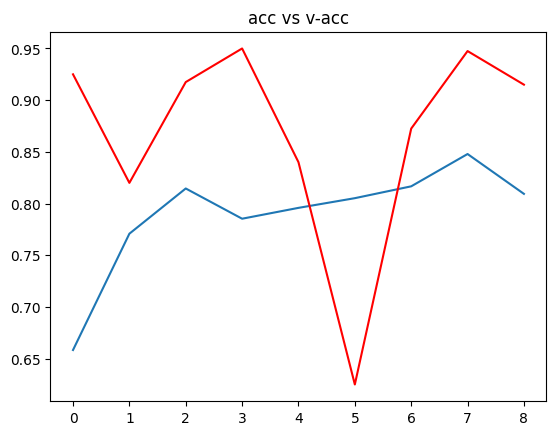

In [11]:
# Plot training and validation accuracy over epochs.
plt.plot(h["accuracy"])
plt.plot(h["val_accuracy"], c="red")
plt.title("acc vs v-acc")
plt.show()

## Plotting Training and Validation Loss

In this section, we generate a plot that visualizes the training and validation loss of the Emotion Detection Model (EmoNet) over multiple epochs. The plot helps us analyze the model's performance during training.


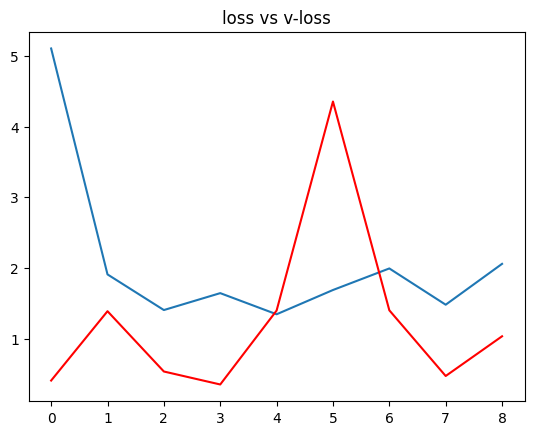

In [12]:
# Plot training and validation loss over epochs.
plt.plot(h["loss"])
plt.plot(h["val_loss"], c="red")
plt.title("loss vs v-loss")
plt.show()

## ROC Curve Evaluation

This section is dedicated to evaluating the model's performance using the Receiver Operating Characteristic (ROC) curve. The ROC curve is a plot of the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings, providing insights into the balance between true positive and false positive rates. The Area Under the Curve (AUC) is also calculated, giving a single measure of the model's performance across all thresholds.

61/61 [==============================] - 54s 872ms/step


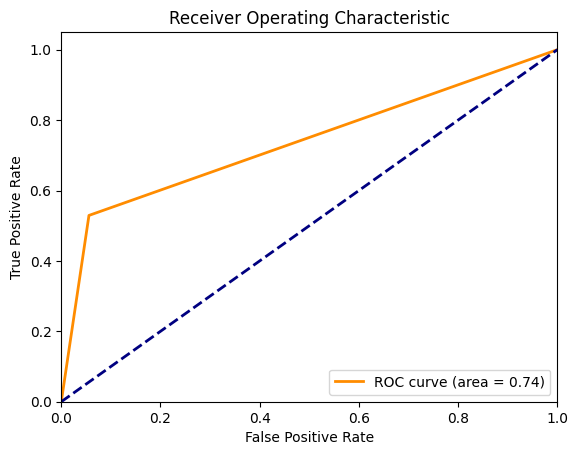

In [13]:
# Predicting the class probabilities using the model on the validation dataset
Y_pred = model.predict(validation_data)

# Converting the probabilities into class labels by selecting the class with the highest probability
y_pred = np.argmax(Y_pred, axis=1)

# Retrieving the actual class labels from the validation dataset
y_true = validation_data.classes

# Calculating the ROC curve data (true positive and false positive rates) and the AUC (Area Under Curve)
fpr, tpr, threshold = roc_curve(
    y_true, y_pred
)  # Calculate false positive rate and true positive rate
roc_auc = auc(fpr, tpr)  # Compute Area Under the Curve

# Plotting the ROC curve
plt.figure()
plt.plot(
    fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc
)  # Plot ROC curve
plt.plot(
    [0, 1], [0, 1], color="navy", lw=2, linestyle="--"
)  # Diagonal line for random model's performance
plt.xlim([0.0, 1.0])  # Limit for x-axis
plt.ylim([0.0, 1.05])  # Limit for y-axis
plt.xlabel("False Positive Rate")  # X-axis label
plt.ylabel("True Positive Rate")  # Y-axis label
plt.title("Receiver Operating Characteristic")  # Title of the plot
plt.legend(loc="lower right")  # Legend of the plot
plt.show()  # Display the plot

## Model Prediction on a Single Image

In this section, we load the trained model saved as 'best_model.h5' and use it to make a prediction on a single image. The process involves loading the image, preprocessing it to match the input format expected by the model, and then using the model to predict the image's class. The predicted class is then displayed along with the image. This allows us to visually inspect the model's performance on individual examples.

1/1 [==============================] - 2s 2s/step
The image is of sad


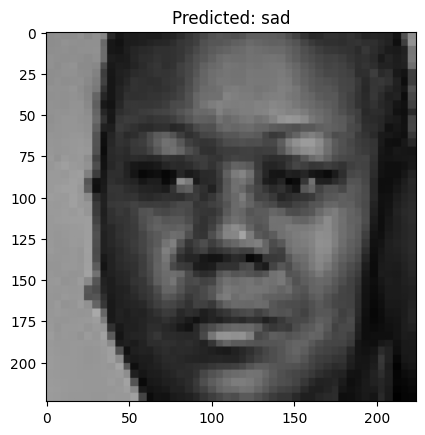

In [14]:
# Load the model
model = load_model("best_model.h5")

# Mapping output values from class indices to class labels
op = dict(zip(train_data.class_indices.values(), train_data.class_indices.keys()))

# Path to a single image for prediction
path = "dataset/train/sad/Training_26728.jpg"  # Replace with the path to your image
img = load_img(path, target_size=(224, 224))  # Load the image and resize it

# Convert the image to a numpy array and scale the pixel values to [0, 1]
i = img_to_array(img) / 255
input_arr = np.array([i])  # Create a batch of one image

# Predict the class of the image
pred = np.argmax(model.predict(input_arr), axis=-1)

# Output the prediction
predicted_class = op[pred[0]]  # Use pred[0] because model.predict returns a batch
print(f"The image is of {predicted_class}")

# Display the image along with the predicted class
plt.imshow(input_arr[0])
plt.title(f"Predicted: {predicted_class}")
# plt.axis("off")  # Corrected line to turn off the axis
plt.show()

## Model Evaluation and Confusion Matrix

In this section, we perform model evaluation by calculating various metrics such as accuracy, precision, recall, and F1 score. Additionally, we compute and visualize the confusion matrix to assess the model's performance on emotion detection.


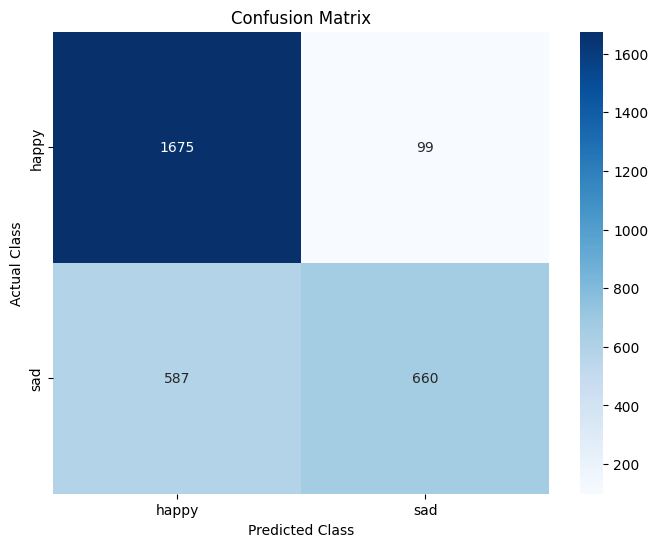

Accuracy: 0.77
Precision: 0.81
Recall: 0.74
F1 Score: 0.74


In [15]:

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate other evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(
    y_true, y_pred, average="macro"
)  # Use 'binary' for binary classification
recall = recall_score(
    y_true, y_pred, average="macro"
)  # Use 'binary' for binary classification
f1 = f1_score(y_true, y_pred, average="macro")  # Use 'binary' for binary classification

# Display the confusion matrix using Seaborn to make it more visual
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=selected_classes,
    yticklabels=selected_classes,
)
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

In [16]:
from sklearn.metrics import classification_report, cohen_kappa_score, matthews_corrcoef

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=selected_classes)
print("Classification Report:\n", report)

# Calculate Cohen's Kappa Score
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa:.2f}")

# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_true, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.2f}")

Classification Report:
               precision    recall  f1-score   support

       happy       0.74      0.94      0.83      1774
         sad       0.87      0.53      0.66      1247

    accuracy                           0.77      3021
   macro avg       0.81      0.74      0.74      3021
weighted avg       0.79      0.77      0.76      3021

Cohen's Kappa Score: 0.50
Matthews Correlation Coefficient: 0.54
